# Convolutional Neural Networks

## Project: 개 품종 분류기를 만들자 

---

이 노트북에서는 project를 수행하기 위한 template code를 제공한다. 아래의 요구 사항을 읽고 project를 완성하기 위한 code를 완성하면 된다.   
**'(IMPLEMENTATION)'** 으로 시작하는 코드 블럭 부분은 반드시 채워 넣어야 제대로 수행된다. 각 section 별로 설명이 제공된다. 설명을 잘 읽고 요구사항에 맞추어 'TODO'부분을 직접 작성하면 된다.

**'Question'** 부분의 질문에 대한 답을 **'Answer:'** 부분에 작성하면 된다.



---
### Project의 목표 

이 project에서는 샘플 이미지에 있는 개를 인식하고 해당 품종을 분류하는 프로그램을 완성한다. project의 마지막 부분에서는 임의의 사진 이미지를 입력으로 받고 해당 이미지에 개가 있는지 detect하여 개가 있으면 개의 품종을 예측하여 출력하는 간단한 프로그램을 작성할 것이다.

![Sample Dog Output](images/sample_dog_output.png)

개의 품종을 분류하기 위해서 CNN을 사용한다. 

### Project 수행단계

이 project를 수행하기 위한 세부 단계는 다음과 같다. 

* **Step 0**: Datasets을 load하고 전처리 한다.
* **Step 1**: 사진 이미지에 개가 있는지 detect한다.
* **Step 2**: CNN을 사용하여 개의 품종을 분류하는 모형을 밑바닥부터 생성한다.(from Scratch)
* **Step 3**: transfer learning을 사용하여 개의 품종을 분류한다.(using Transfer Learning)
* **Step 5**: 임의의 사진 이미지를 입력으로 받아 개의 품종을 예측하여 출력하는 프로그램을 작성한다.


---

## Step 0: Datasets을 load하고 전처리 한다.

[dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip) 을 다운로드 하여 현재 디렉토리에 `/data/dog_images` 압축해제한다.


In [1]:
import numpy as np
from glob import glob

dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


---
## Step 1: Detect Dogs

Step 1에서는 [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html)을 사용하여 사진 이미지에서 개가 있는지 여부를 dectec하고자 한다.

### Obtain Pre-trained VGG-16 Model

다음과 같이 VGG-16 model을 다운로드 한다. VGG-16은 ImageNet으로 훈련된 모형으로 1000개의 class로 이미지를 분류한다.[1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  




In [6]:
import torch
import torchvision.models as models
import os

os.environ['TORCH_HOME'] = '../models'

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 104970327.32it/s]


### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

다음의 code cell에서 이미지를 입력으로 받아 해당 이미지의 class를 예측하는 함수를 만드시오.

예를들면, `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`를 입력으로 받아서 pre-trained model을 통해 예측한 ImageNet class 값을 리턴 하면 된다. 



In [7]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    output = None
    
    image = Image.open(img_path)
    transform = transforms.Compose([transforms.Resize(256), 
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                   ])
        
    preprocessed = transform(image)[:3,:,:].unsqueeze(0)
    
    if use_cuda:
        preprocessed = preprocessed.cuda()
        
    _, class_index = torch.max(VGG16(preprocessed),1)
    
    output = class_index.item()
    
    return output # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

다음 링크--> [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)를 참조해 보면 ImageNet의 1000개 class 중 151-268번에 해당하는 것이 개와 관련된 class임을 알 수 있다. 예를 들면 `'Chihuahua'`에서 `'Mexican hairless'`까지 이다. 따라서 pre-trained VGG-16 model이 예측하는 것이 151에서 268 사이의 index값을 리턴한다면 해당 이미지에서 개가 있다고 할 수 있다.

이를 이용하여 `dog_detector` function을 작성한다.   
precition index가 151~268 사이이면 개가 이미지에 있다고 판단하여 `True`를 리턴하고 그렇지 않으면  `False`를 리턴하도록 한다.



In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    pred = VGG16_predict(img_path)
    return (pred >= 151 and pred <= 268) # true/false

---

## Step 2: Create a CNN to Classify Dog Breeds (from Scratch)

앞의 dog_detector fuction을 사용하여 개가 이미지에 있는지를 detect해 보았다. 

이번 section에서는 이미지에서 개의 품종을 예측하는 분류 모형을 생성해보자. 

Transfer Learning을 이용하지 않고 밑바닥부터 CNN 모형을 생성하도록 한다. 해당 모형의 test accuracy가 최소한 10%는 넘도록 모형을 훈련하여야 한다.   

생성되는 모형의 구조, 하이퍼파라미터, 옵티마이저, 손실함수 등은 자유롭게 설정하도록 한다.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

디렉토리에 저장되어 있는 개 이미지를 ImageFolder로 읽어 들인다. 해당 디렉토리는 각각  `dog_images/train`, `dog_images/valid`, `dog_images/test`로 나뉘어 있는데 이를 각각 train, valid, test dataloader로 생성한다. [custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html)을 참조할 수 있다. image augmentation을 수행하려면 [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)을 참조한다.


In [11]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

imsize = 224
batch_size = 50
num_workers = 4

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(imsize),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(imsize),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(imsize),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/data/dog_images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid','test']}
loaders_scratch = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
                   for x in ['train', 'valid','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid','test']}

class_names = image_datasets['train'].classes
num_classes = len(image_datasets['train'].classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Train dataset size: {}'.format(dataset_sizes['train']))
print('Valid dataseet size: {}'.format(dataset_sizes['valid']))
print('Test dataseet size: {}'.format(dataset_sizes['test']))
print('Number of classes; {}'.format(num_classes))

Train dataset size: 6680
Valid dataseet size: 835
Test dataseet size: 836
Number of classes; 133


**Question :** 이미지 데이터 전처리에 대하여 다음 질문에 답해보시오. 
- 어떤 방법으로 이미지 사이즈를 조정하였나? input tensor 사이즈를 얼마로 조정하였는가? 왜 그렇게 하였는가?
- Data augmentation을 수행하였는가? 어떤 방법으로 augmentation하였는가? (translations, flips, rotations, etc)? augmentation을 했거나 하니 않았거나, 그렇게 한 이유는 무엇인가? 


**Answer**: 

> **이곳을 더블클릭하여 여러분의 답변을 적으시오.**


### (IMPLEMENTATION) Model Architecture

개 품종을 분류하는 CNN 모형을 작성하시오. 아래의 template code를 적절히 활용하시오.


In [12]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(128*7*7, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        ## Define forward behavior
        # conv1
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # conv2
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # conv3
        x = F.relu(self.conv3(x))
        x = self.pool(x)
                        
        # flatten image
        x = x.view(-1, 128*7*7)
        
        # fc
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [13]:
model_scratch

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=133, bias=True)
  (dropout): Dropout(p=0.5)
)

__Question :__ 다음 질문에 답해 보시오.

* Kernel 사이즈는 얼마로 하였는가? stride, padding은 어떻게 정하였는가?
* 몇 개의 Convnet을 어떻게 구성하였는가?
* dropout을 사용하였는가?



__Answer:__ 

> **이곳을 더블클릭하여 여러분의 답변을 적으시오.**


### (IMPLEMENTATION) Specify Loss Function and Optimizer

[loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) 와 [optimizer](http://pytorch.org/docs/stable/optim.html) 를 선택한다. 

In [14]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01, momentum = 0.9)

### (IMPLEMENTATION) Train and Validate the Model

생성한 모형을 훈련하고 validation을 수행한다.훈련된 모형은 `'model_scratch.pt'` 파일로 저장하시오.  
[Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html)

In [15]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
           
            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased from ({:.6f} --> {:.6f}). Model saving...'.format(
                   valid_loss_min,
                   valid_loss
                   ))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss    
            
    # return trained model
    return model


# train the model
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # To avoid "osError: image file is truncated"

model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.879547 	Validation Loss: 4.847648
Validation loss decreased from (inf --> 4.847648). Model saving...
Epoch: 2 	Training Loss: 4.827935 	Validation Loss: 4.729733
Validation loss decreased from (4.847648 --> 4.729733). Model saving...
Epoch: 3 	Training Loss: 4.722699 	Validation Loss: 4.535847
Validation loss decreased from (4.729733 --> 4.535847). Model saving...
Epoch: 4 	Training Loss: 4.624000 	Validation Loss: 4.508413
Validation loss decreased from (4.535847 --> 4.508413). Model saving...
Epoch: 5 	Training Loss: 4.582239 	Validation Loss: 4.525342
Epoch: 6 	Training Loss: 4.522315 	Validation Loss: 4.348920
Validation loss decreased from (4.508413 --> 4.348920). Model saving...
Epoch: 7 	Training Loss: 4.478040 	Validation Loss: 4.332617
Validation loss decreased from (4.348920 --> 4.332617). Model saving...
Epoch: 8 	Training Loss: 4.444126 	Validation Loss: 4.202794
Validation loss decreased from (4.332617 --> 4.202794). Model saving...
Epoch: 9 	Tra

### (IMPLEMENTATION) Test the Model

위에서 작성한 모형에 대해 test를 진행하시오. test loss와 test accuracy를 출력하시오. test accuracy는 10% 이상이 되어야 한다.


In [16]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.423006


Test Accuracy: 18% (158/836)


---

## Step 3: Create a CNN to Classify Dog Breeds (using Transfer Learning)

transfer learning 을 사용하여 개의 품종을 예측하는 모형을 생성하시오. 생성된 모형의 test accuracy는 최소한 60% 이상을 달성하도록 하시오.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

**앞서 작성한 데이터 로더를 그대로 사용할 수 있다.**


In [17]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch.copy()

### (IMPLEMENTATION) Model Architecture

transfer learning을 사용하여 개의 품종을 예측 분류하는 모형을 생성하시오. 

In [18]:
import torchvision.models as models
import torch.nn as nn
import os

os.environ['TORCH_HOME'] = '../models'

## TODO: Specify model architecture 

model_transfer = models.resnet18(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False

num_ftrs = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(num_ftrs, num_classes)

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 28419370.32it/s]


__Question :__  다음 질문에 답하시오.
* pretrained model로 어떤 모형을 사용하였는가? 이유는 무엇인가?
* parameter를 freeze하였는가?
* 마지막 FC layer를 어떻게 수정하여 classifier를 생성하였는가?



__Answer:__ 

> **이곳을 더블클릭하여 답변을 작성하시오.**


### (IMPLEMENTATION) Specify Loss Function and Optimizer

[loss function](http://pytorch.org/docs/master/nn.html#loss-functions) 와 [optimizer](http://pytorch.org/docs/master/optim.html)을 설정하시오.


In [22]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.01, momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

모형을 훈련하고 validation결과를 확인하시오. 생성된 최종 모형은 `'model_transfer.pt'` 파일로 저장하시오.


In [23]:
# train the model
n_epochs = 30
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.414644 	Validation Loss: 1.221094
Validation loss decreased from (inf --> 1.221094). Model saving...
Epoch: 2 	Training Loss: 1.499097 	Validation Loss: 0.847836
Validation loss decreased from (1.221094 --> 0.847836). Model saving...
Epoch: 3 	Training Loss: 1.263642 	Validation Loss: 0.711890
Validation loss decreased from (0.847836 --> 0.711890). Model saving...
Epoch: 4 	Training Loss: 1.091921 	Validation Loss: 0.653619
Validation loss decreased from (0.711890 --> 0.653619). Model saving...
Epoch: 5 	Training Loss: 1.026934 	Validation Loss: 0.593977
Validation loss decreased from (0.653619 --> 0.593977). Model saving...
Epoch: 6 	Training Loss: 0.983820 	Validation Loss: 0.580292
Validation loss decreased from (0.593977 --> 0.580292). Model saving...
Epoch: 7 	Training Loss: 0.910773 	Validation Loss: 0.548619
Validation loss decreased from (0.580292 --> 0.548619). Model saving...
Epoch: 8 	Training Loss: 0.886533 	Validation Loss: 0.539539
Validation lo

### (IMPLEMENTATION) Test the Model

생성된 모형을 test하시오. 테스트 결과는 test accuracy가 60% 이상이 되어야 한다.


In [24]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.485156


Test Accuracy: 84% (703/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

개의 품종을 예측하는 다음의 함수를 완성하시오.  

입력으로 사진이미지 파일을 받아서 개의 품종을 출력하시오. (예를 들면, `Affenpinscher`, `Afghan hound`, 등등)


In [25]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path)
    
    img_transform = transforms.Compose([
        transforms.Resize(254),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    img = img_transform(img)
    if use_cuda:
        img = img.cuda()
        
    image = img.unsqueeze(0)
    
    model_transfer.eval()
    
    output = model_transfer(image)
    
    p, idx = torch.max(F.softmax(output, dim=1),1) # p = probability 
    
    breed_name = class_names[idx]
    
    return breed_name, p.item()

---

## Step 4: Write your Algorithm

다음과 같은 함수를 작성하시오.  

- 이미지에서 개가 detect 되면 개의 품종을 예측하여 출력하시오.
- 이미지에서 개가 detect 되지 않으면 에러 메세지를 출력하도록 하시오.



### (IMPLEMENTATION) Write your Algorithm

In [26]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    img = Image.open(img_path)
    plt.title('Input Image...')
    plt.imshow(img)
    plt.show()
    
    if dog_detector(img_path):
        breed, p = predict_breed_transfer(img_path)
        print(" ===> Dog Detected... This dog is '{}'({:.2f}%).".format(breed,p*100))
    else :
        print(" ===> Error... I could not detect Dog.")



## Sample Test

임의의 이미지로 위에서 작성한 함수를 테스트해서 제대로 된 결과가 나오는지 확인하시오.

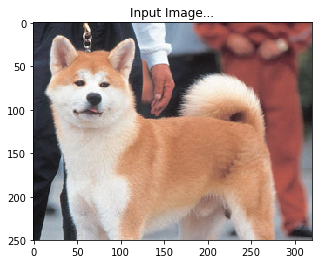

 ===> Dog Detected... This dog is 'Akita'(99.59%).


In [28]:
# Test dog image
run_app('/data/dog_images/train/004.Akita/Akita_00221.jpg')

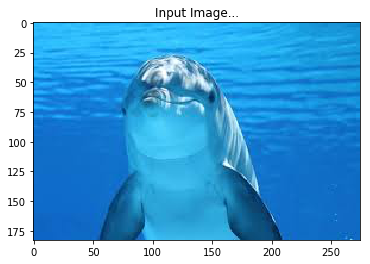

 ===> Error... I could not detect Dog or Human.


In [29]:
# Not dog
run_app('./images/dolphin.jpg')

__Question :__ 최종 결과를 확인하고 다음의 질문에 답하시오.

* 최종 모형을 개선할 수 있는 방법에 대해서 생각해 보시오.
* test accuracy를 높이기 위해서 추가적으로 고려 할 수 있는 방법으로는 어떤게 있을까? 



__Answer:__ 
> **여기에 여러분의 답을 작성해보시오.**
